In [53]:
import numpy as np
import SimpleITK as sitk
import json
import shutil
import subprocess
import sys
import time
import pickle
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from pathlib import Path
from skimage.exposure import match_histograms

thispath = Path().resolve()
base_path = thispath.parent
sys.path.insert(0, str(base_path))

import elastix.elastix_utils as e_utils
from utils.metrics import mutual_information
from utils import utils
from preprocessing import min_max_norm


### Tissue model for generating a probabilistic atlas from training cases

In [56]:
# Define paths
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas'

# Read reference image 
ref_img_path = train_set_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ref_img_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)

# Define placeholder for the tissue models
t_models = np.zeros((4, 255))

# For every case in the train set
for case_path in train_set_path.iterdir():

    case = case_path.name
    
    # Define paths
    seg_path = case_path / f'{case}_seg.nii.gz'
    case_img_path = case_path / f'{case}_n4.nii.gz'
    
    # Read images
    case_img = sitk.ReadImage(str(case_img_path))
    case_img_array = sitk.GetArrayFromImage(case_img)
    # Read the ground truth
    seg_img = sitk.ReadImage(str(seg_path))
    seg_img_array = sitk.GetArrayFromImage(seg_img)
    
    # Match histograms
    case_img_array[case_img_array!=0] = match_histograms(case_img_array[case_img_array!=0], ref_img_array[ref_img_array!=0])
    labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

    # Accumulate the histograms
    for c in labels_keys.keys():
        t_models[c, :] += np.histogram(case_img_array[seg_img_array == c], bins=255, range=[0, 256])[0]

# Compute the probability density function
t_models = t_models / np.sum(t_models, axis=1)[:, None]
t_sum = np.sum(t_models, axis=0)[None, :]
t_sum = np.where(t_sum == 0, 1, t_sum)

# Obtain the posterior probability from the likelihood
t_models = t_models / np.repeat(t_sum, 4, axis=0)

# Fix values in the start and the end to ensure consistency
t_models[0, 6:14] = 0
t_models[1, 0:14] = 1
t_models[3, 175:] = 1
t_models[0:3, 175:] = 0

# Store the tissue models
with open(data_path / 'tissue_models/tissue_models_3C.pkl', 'wb') as p_file:
    pickle.dump(t_models[1:,:], p_file)

### Plot the tissue model

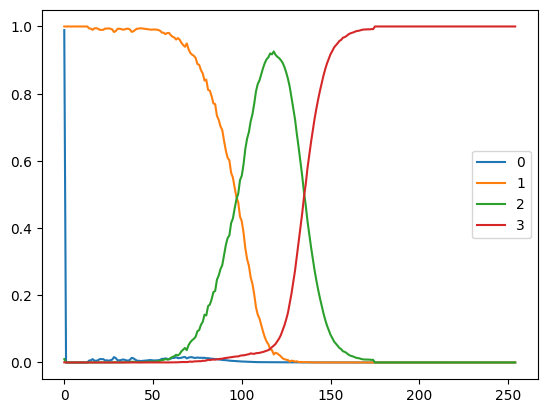

In [57]:
plt.figure()
for i in range(4):
    plt.plot(t_models[i, :], label=i)
plt.legend()
plt.show()

### Experiment generating a tissue models for each case based on the multi-atlas registration to a single target image

In [ ]:
# Define paths
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas'

# Read reference image 
ref_img_path = train_set_path / 'IBSR_18/IBSR_18_n4.nii.gz'
ref_img = sitk.ReadImage(str(ref_img_path))
ref_img_array = sitk.GetArrayFromImage(ref_img)

# Define the placeholder for the tissue models
t_models = np.zeros((4, 255))

# Separate train and val cases
train_cases = [c.name for c in train_set_path.iterdir()]
val_cases = [c.name for c in val_set_path.iterdir()]
all_cases = train_cases + val_cases

# For each target case, compute a tissue model
for fix_case in all_cases:
    
    # Load the target case
    partition = 'train_set' if fix_case in train_cases else 'validation_set'
    fix_case_path = data_path / partition / fix_case
    fix_img_path = data_path / partition / fix_case / f'{fix_case}_n4.nii.gz'
    fix_img = sitk.ReadImage(str(fix_img_path))
    fix_img_array = sitk.GetArrayFromImage(fix_img)

    # For each atlas wrt that target case:
    for case in all_cases:
        # avoid treating the target as an atlas
        if case == fix_case:
            continue
        partition = 'train_set' if case in train_cases else 'validation_set'
        case_path = data_path / partition / case

        # Define paths
        seg_path = case_path / f'{case}_seg.nii.gz'
        case_img_path = case_path / f'{case}_n4.nii.gz'

        # Read images
        case_img = sitk.ReadImage(str(case_img_path))
        case_img_array = sitk.GetArrayFromImage(case_img)
        seg_img = sitk.ReadImage(str(seg_path))
        seg_img_array = sitk.GetArrayFromImage(seg_img)

        # Match histograms
        case_img_array[case_img_array!=0] = match_histograms(case_img_array[case_img_array!=0], fix_img_array[fix_img_array!=0])
        labels_keys = {0: 'background', 1: 'csf', 2: 'gm', 3: 'wm'}

        # Accumulate histograms
        for c in labels_keys.keys():
            t_models[c, :] += np.histogram(case_img_array[seg_img_array == c], bins=255, range=[0, 256])[0]

    # Compute the PDF
    t_models = t_models / np.sum(t_models, axis=1)[:, None]
    t_sum = np.sum(t_models, axis=0)[None, :]
    t_sum = np.where(t_sum == 0, 1, t_sum)
    # Compute the posterior based on the likelihoods
    t_models = t_models / np.repeat(t_sum, 4, axis=0)

    # Fix values in the start and the end to ensure consistency
    t_models[0, 6:14] = 0
    t_models[1, 0:14] = 1

    # Store the tissue models
    with open(data_path / f'tissue_models/tissue_models_{fix_case}_3C.pkl', 'wb') as p_file:
        pickle.dump(t_models[1:,:], p_file)
    
    # Plot the tissue models
    # plt.figure()
    # for i in range(4):
    #     plt.plot(t_models[i, :], label=i)
    # plt.legend()
    # plt.show()